In [25]:
import numpy as np
import pandas as pd

import re
import string
import nltk
from nltk.corpus import stopwords
import texthero as hero
from wordcloud import WordCloud

import lightgbm as lgb
from lightgbm import LGBMClassifier

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV, StratifiedKFold, RandomizedSearchCV, cross_val_score

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set()

import os

import warnings
warnings.filterwarnings("ignore")

INPUT = "./data/"
OUTPUT = "./output/"

In [2]:
print(os.listdir("./data"))

['sample_submission.csv', 'test.csv', 'train.csv']


In [3]:
train = pd.read_csv(INPUT + "train.csv")
test = pd.read_csv(INPUT + "test.csv")
print(train.shape, test.shape)

(7613, 5) (3263, 4)


In [4]:
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [5]:
print(train.isnull().sum())
print(test.isnull().sum())

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64
id             0
keyword       26
location    1105
text           0
dtype: int64


In [6]:
train["target"].value_counts()

0    4342
1    3271
Name: target, dtype: int64

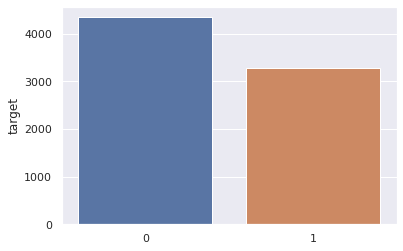

In [7]:
sns.barplot(train["target"].value_counts().index, train["target"].value_counts())

In [8]:
disaster_tweets = train[train["target"] == 1]["text"]
disaster_tweets.values[3]

'13,000 people receive #wildfires evacuation orders in California '

In [9]:
non_disaster_tweets = train[train["target"] == 0]["text"]
non_disaster_tweets.values[10]

"No way...I can't eat that shit"

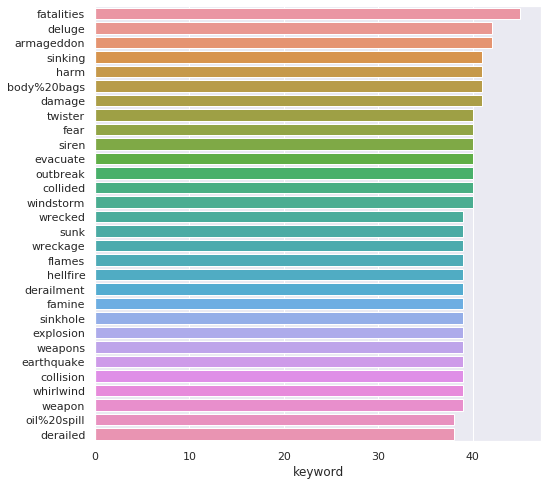

In [10]:
plt.figure(figsize=(8, 8))
sns.barplot(y=train["keyword"].value_counts()[:30].index, x=train["keyword"].value_counts()[:30])
plt.show()

In [11]:
train.loc[train["text"].str.contains("disaster", na=False, case=False)].target.value_counts()

1    102
0     40
Name: target, dtype: int64

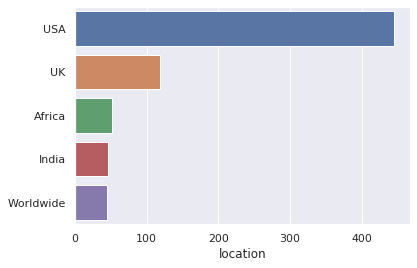

In [12]:
train['location'].replace({'United States':'USA',
                           'New York':'USA',
                            "London":'UK',
                            "Los Angeles, CA":'USA',
                            "Washington, D.C.":'USA',
                            "California":'USA',
                             "Chicago, IL":'USA',
                             "Chicago":'USA',
                            "New York, NY":'USA',
                            "California, USA":'USA',
                            "FLorida":'USA',
                            "Nigeria":'Africa',
                            "Kenya":'Africa',
                            "Everywhere":'Worldwide',
                            "San Francisco":'USA',
                            "Florida":'USA',
                            "United Kingdom":'UK',
                            "Los Angeles":'USA',
                            "Toronto":'Canada',
                            "San Francisco, CA":'USA',
                            "NYC":'USA',
                            "Seattle":'USA',
                            "Earth":'Worldwide',
                            "Ireland":'UK',
                            "London, England":'UK',
                            "New York City":'USA',
                            "Texas":'USA',
                            "London, UK":'UK',
                            "Atlanta, GA":'USA',
                            "Mumbai":"India"},inplace=True)

sns.barplot(y=train['location'].value_counts()[:5].index,x=train['location'].value_counts()[:5],
            orient='h')

In [13]:
train["text"][:5]

0    Our Deeds are the Reason of this #earthquake M...
1               Forest fire near La Ronge Sask. Canada
2    All residents asked to 'shelter in place' are ...
3    13,000 people receive #wildfires evacuation or...
4    Just got sent this photo from Ruby #Alaska as ...
Name: text, dtype: object

In [14]:
custom_pipeline = [
    hero.preprocessing.lowercase,
    hero.preprocessing.remove_urls,
    hero.preprocessing.remove_whitespace,
    hero.preprocessing.remove_punctuation,
    hero.preprocessing.remove_brackets,
    hero.preprocessing.remove_digits,
]
train["text"] = hero.clean(train["text"], pipeline=custom_pipeline)
test["text"] = hero.clean(test["text"], pipeline=custom_pipeline)

In [15]:
train["text"].head()

0    our deeds are the reason of this  earthquake m...
1               forest fire near la ronge sask  canada
2    all residents asked to  shelter in place  are ...
3        people receive  wildfires evacuation order...
4    just got sent this photo from ruby  alaska as ...
Name: text, dtype: object

Text(0.5, 1.0, 'Non Disaster Tweets')

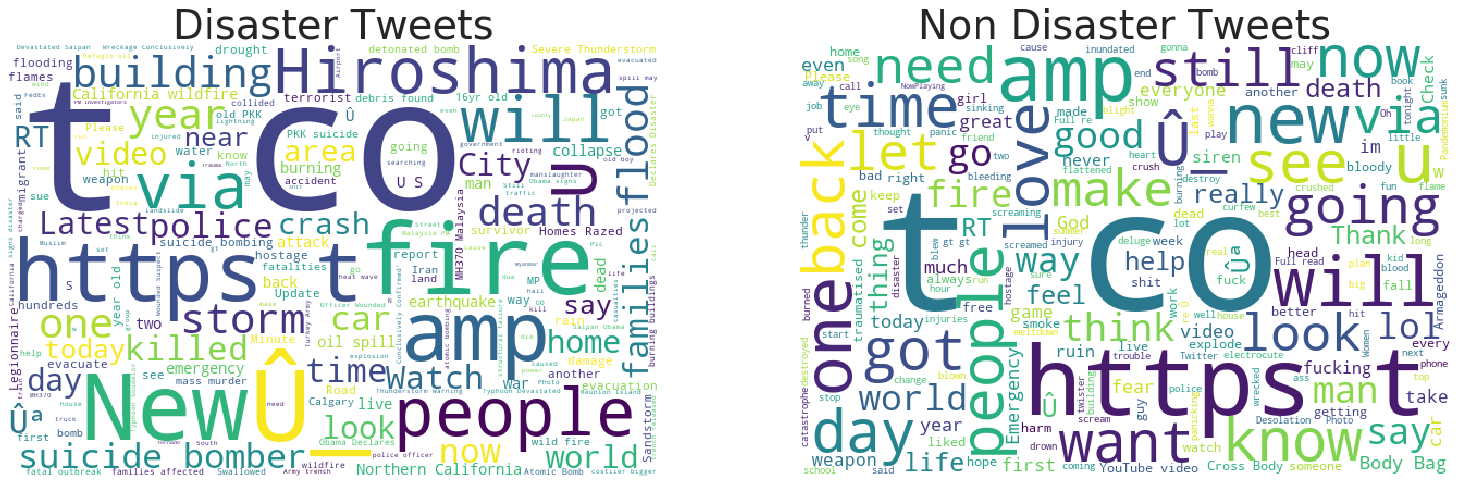

In [16]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[26, 8])
wordcloud1 = WordCloud(background_color="white", width=600, height=400).generate(" ".join(disaster_tweets))
ax1.imshow(wordcloud1)
ax1.axis("off")
ax1.set_title("Disaster Tweets", fontsize=40)

wordcloud2 = WordCloud(background_color="white", width=600, height=400).generate(" ".join(non_disaster_tweets))
ax2.imshow(wordcloud2)
ax2.axis("off")
ax2.set_title("Non Disaster Tweets", fontsize=40)

In [17]:
text = "Are you coming , aren't you"
tokenizer1 = nltk.tokenize.WhitespaceTokenizer()
tokenizer2 = nltk.tokenize.TreebankWordTokenizer()
tokenizer3 = nltk.tokenize.WordPunctTokenizer()
tokenizer4 = nltk.tokenize.RegexpTokenizer(r'\w+')

print("Example Text:", text)
print("_"*70)
print("Tokenization by whitespace:- ",tokenizer1.tokenize(text))
print("Tokenization by words using Treebank Word Tokenizer:- ",tokenizer2.tokenize(text))
print("Tokenization by punctuation:- ",tokenizer3.tokenize(text))
print("Tokenization by regular expression:- ",tokenizer4.tokenize(text))

Example Text: Are you coming , aren't you
______________________________________________________________________
Tokenization by whitespace:-  ['Are', 'you', 'coming', ',', "aren't", 'you']
Tokenization by words using Treebank Word Tokenizer:-  ['Are', 'you', 'coming', ',', 'are', "n't", 'you']
Tokenization by punctuation:-  ['Are', 'you', 'coming', ',', 'aren', "'", 't', 'you']
Tokenization by regular expression:-  ['Are', 'you', 'coming', 'aren', 't', 'you']


In [18]:
tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
train["text"] = train['text'].apply(lambda x: tokenizer.tokenize(x))
test["text"] = test['text'].apply(lambda x: tokenizer.tokenize(x))
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,"[our, deeds, are, the, reason, of, this, earth...",1
1,4,NaN,NaN,"[forest, fire, near, la, ronge, sask, canada]",1
2,5,NaN,NaN,"[all, residents, asked, to, shelter, in, place...",1
3,6,NaN,NaN,"[people, receive, wildfires, evacuation, order...",1
4,7,NaN,NaN,"[just, got, sent, this, photo, from, ruby, ala...",1


In [19]:
def remove_stopwords(text):
    """
    Removing stopwords belonging to english language
    
    """
    words = [w for w in text if w not in stopwords.words('english')]
    return words


train['text'] = train['text'].apply(lambda x : remove_stopwords(x))
test['text'] = test['text'].apply(lambda x : remove_stopwords(x))
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,"[deeds, reason, earthquake, may, allah, forgiv...",1
1,4,NaN,NaN,"[forest, fire, near, la, ronge, sask, canada]",1
2,5,NaN,NaN,"[residents, asked, shelter, place, notified, o...",1
3,6,NaN,NaN,"[people, receive, wildfires, evacuation, order...",1
4,7,NaN,NaN,"[got, sent, photo, ruby, alaska, smoke, wildfi...",1


In [20]:
text = "feet cats wolves talked"

tokenizer = nltk.tokenize.TreebankWordTokenizer()
tokens = tokenizer.tokenize(text)

# Stemmer
stemmer = nltk.stem.PorterStemmer()
print("Stemming the sentence: ", " ".join(stemmer.stem(token) for token in tokens))

# Lemmatizer
lemmatizer=nltk.stem.WordNetLemmatizer()
print("Lemmatizing the sentence: ", " ".join(lemmatizer.lemmatize(token) for token in tokens))

Stemming the sentence:  feet cat wolv talk
Lemmatizing the sentence:  foot cat wolf talked


In [21]:
def combine_text(list_of_text):
    combine_text = ' '.join(list_of_text)
    return combine_text

train["text"] = train["text"].apply(lambda x: combine_text(x))
test["text"] = test["text"].apply(lambda x: combine_text(x))
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,deeds reason earthquake may allah forgive us,1
1,4,NaN,NaN,forest fire near la ronge sask canada,1
2,5,NaN,NaN,residents asked shelter place notified officer...,1
3,6,NaN,NaN,people receive wildfires evacuation orders cal...,1
4,7,NaN,NaN,got sent photo ruby alaska smoke wildfires pou...,1


In [23]:
count_vectorizer = CountVectorizer()
train_vectors = count_vectorizer.fit_transform(train["text"])
test_vectors = count_vectorizer.transform(test["text"])
print(train_vectors[0].todense())

[[0 0 0 ... 0 0 0]]


In [24]:
tfidf = TfidfVectorizer(min_df=2, max_df=0.5, ngram_range=(1, 2))
train_tfidf = tfidf.fit_transform(train["text"])
test_tfidf = tfidf.transform(test["text"])

In [26]:
clf = LogisticRegression(C=1.0)
scores = cross_val_score(clf, train_vectors, train["target"], cv=5, scoring="f1")
scores

array([0.60676329, 0.50215703, 0.58813839, 0.50096339, 0.70876085])

In [27]:
clf.fit(train_vectors, train["target"])

LogisticRegression()

In [29]:
clf_tfidf = LogisticRegression(C=1.0)
scores = cross_val_score(clf_tfidf, train_tfidf, train["target"], cv=5, scoring="f1")
scores

array([0.58110883, 0.50280374, 0.54844607, 0.44885177, 0.66372462])

In [30]:
clf_NB = MultinomialNB()
scores = cross_val_score(clf_NB, train_vectors, train["target"], cv=5, scoring="f1")
scores

array([0.63002461, 0.6061915 , 0.68357999, 0.6375682 , 0.72402383])

In [31]:
clf_NB_TFIDF = MultinomialNB()
scores = cross_val_score(clf_NB_TFIDF, train_vectors, train["target"], cv=5, scoring="f1")
scores

array([0.63002461, 0.6061915 , 0.68357999, 0.6375682 , 0.72402383])